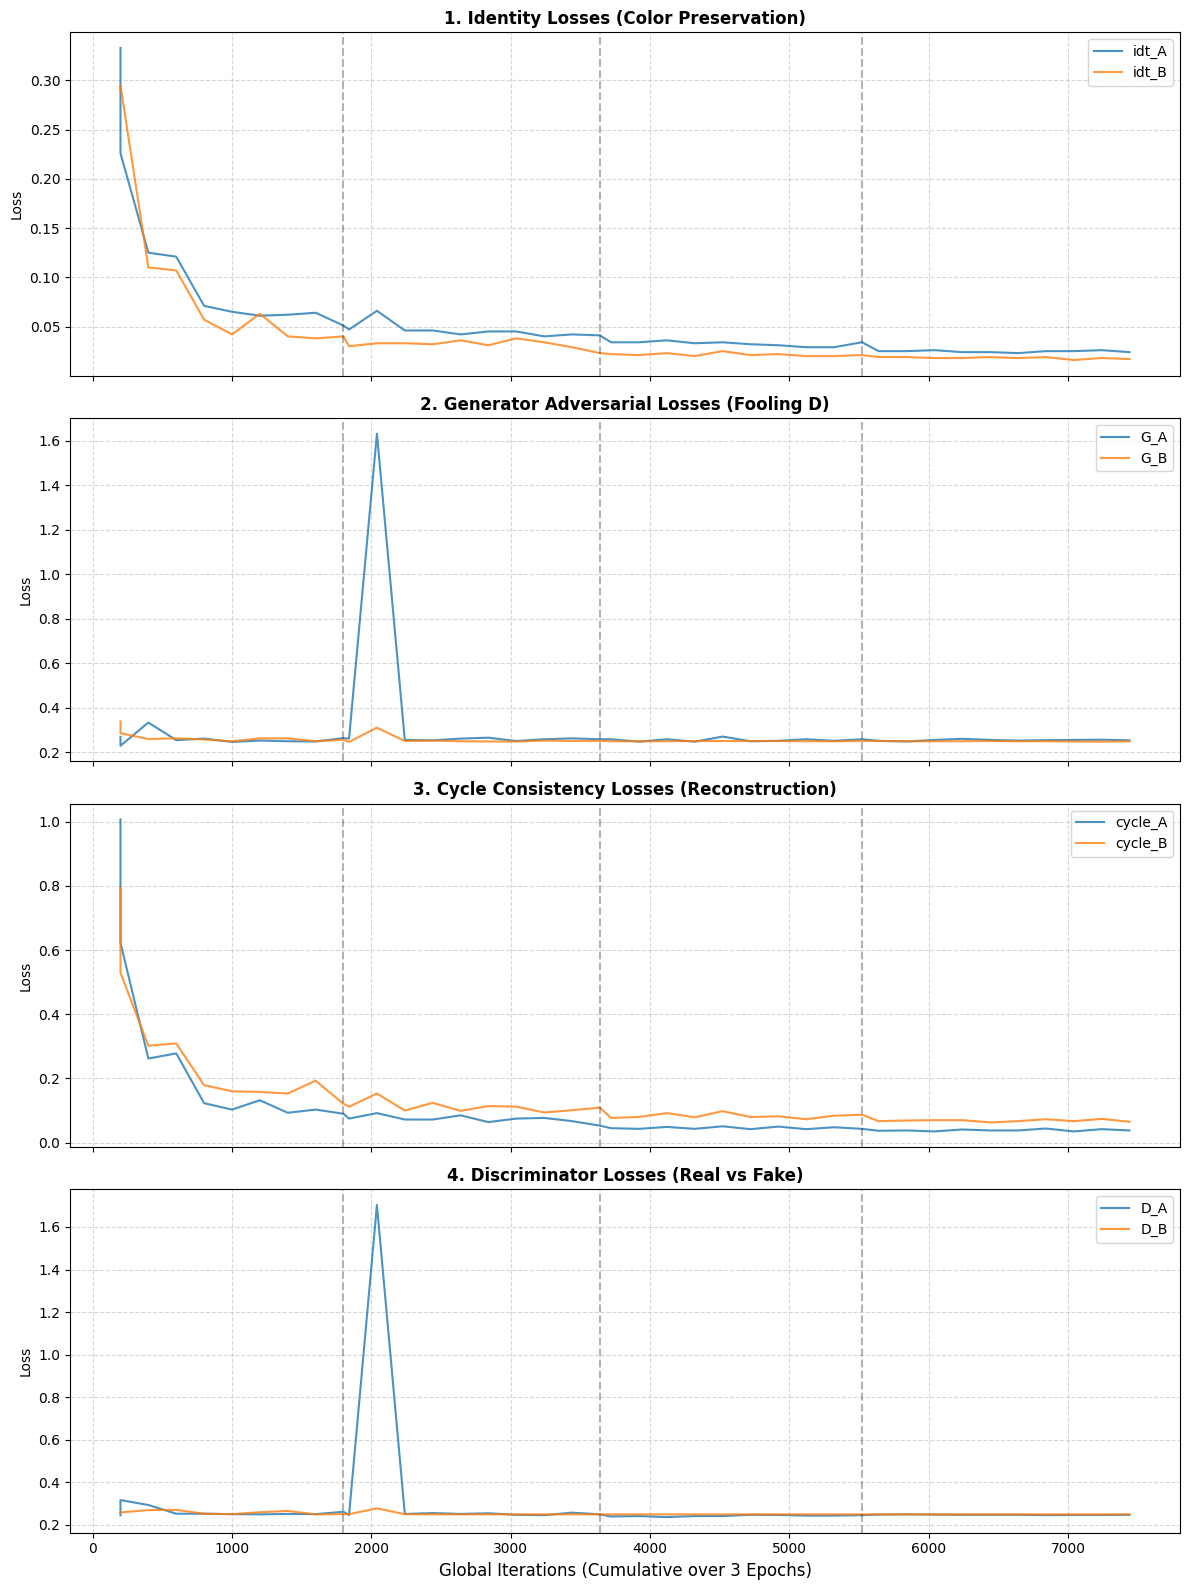

In [ ]:
import matplotlib.pyplot as plt
import re

filename = 'results/loss_log3.txt' 

# Data storage
global_iterations = [] 
losses = {
    'D_A': [], 'G_A': [], 'cycle_A': [], 'idt_A': [],
    'D_B': [], 'G_B': [], 'cycle_B': [], 'idt_B': []
}

# Variables to handle epoch continuity (resetting iterations)
offset = 0
last_iter = 0
epoch_boundaries = [] # To store where new epochs begin

try:
    with open(filename, 'r') as f:
        for line in f:
            # Skip lines that don't contain iteration info
            if "iters:" not in line:
                continue

            # Extract current iteration number
            iter_match = re.search(r'iters:\s+(\d+)', line)
            if iter_match:
                current_iter = int(iter_match.group(1))
                
                # --- EPOCH DETECTION LOGIC ---
                # If the current iteration is smaller than the previous one,
                # it means a new epoch has started. We update the offset.
                if current_iter < last_iter:
                    offset += last_iter
                    epoch_boundaries.append(offset)
                
                # Calculate global iteration (absolute/cumulative)
                global_iter = current_iter + offset
                global_iterations.append(global_iter)
                
                # Update last known iteration
                last_iter = current_iter
            
                # Extract loss values
                for key in losses.keys():
                    loss_match = re.search(rf'{key}:\s+([\d\.]+)', line)
                    if loss_match:
                        losses[key].append(float(loss_match.group(1)))
                    else:
                        losses[key].append(None)
                    

    # --- PLOTTING ---
    # Create 4 stacked subplots sharing the same X-axis
    # Increased height (16) to accommodate the 4th graph
    fig, (ax_id, ax_gen, ax_cycle, ax_disc) = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

    # Define groups for each subplot
    group_id    = ['idt_A', 'idt_B']
    group_gen   = ['G_A', 'G_B']         # Pure adversarial loss
    group_cycle = ['cycle_A', 'cycle_B'] # Cycle consistency loss
    group_disc  = ['D_A', 'D_B']

    # Helper function to plot on a specific axis
    def plot_on_axis(ax, keys, title):
        for key in keys:
            values = losses[key]
            # Filter out None values to keep lines clean
            valid_data = [(i, v) for i, v in zip(global_iterations, values) if v is not None]
            if valid_data:
                valid_iters, valid_vals = zip(*valid_data)
                ax.plot(valid_iters, valid_vals, label=key, linewidth=1.5, alpha=0.8)
        
        # Draw vertical lines for Epochs
        for boundary in epoch_boundaries:
            ax.axvline(x=boundary, color='black', linestyle='--', alpha=0.3)
            
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_ylabel("Loss")
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.5)

    # Plotting the 4 distinct levels
    plot_on_axis(ax_id,    group_id,    "1. Identity Losses (Color Preservation)")
    plot_on_axis(ax_cycle, group_cycle, "2. Cycle Consistency Losses (Reconstruction)")
    plot_on_axis(ax_gen,   group_gen,   "3. Generator Adversarial Losses (Fooling D)")
    plot_on_axis(ax_disc,  group_disc,  "4. Discriminator Losses (Real vs Fake)")

    # Set X-label only on the bottom graph
    ax_disc.set_xlabel("Global Iterations (Cumulative over 3 Epochs)", fontsize=12)

    plt.tight_layout()
    
    # Optional: Save the figure
    # plt.savefig('cyclegan_losses_4_levels.png', dpi=300)
    
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{filename}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")